In [1]:
import glob
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom as dicom
import os
import math
import matplotlib.pyplot as plt

from scipy import ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
data_dir = 'D:/Project/Lung Nodule/kaggle/stage1/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('D:/Project/Lung Nodule/kaggle/csv/stage1_labels.csv', index_col=0)

labels_df.head()

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [3]:
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    
    # a couple great 1-liners from: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(len(slices),label)
    print(slices[0])

C:\Users\Marya\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


195 1
(0008, 0000) Group Length                        UL: 358
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.321555830121981826540353244716
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0000) Group Length                        UL: 64
(0010, 0010) Patient's Name                      PN: '0015ceb851d7251b8f399e39779d1e7d'
(0010, 0020) Patient ID                          LO: '0015ceb851d7251b8f399e39779d1e7d'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 0000) Group Length                        UL: 390
(0020, 000d) Study Instance UID                  UI: 2.25.51820907428519808061667399603379702974102486079290552633235
(0020, 000e) Series Instance UID     

In [8]:
for patient in patients[:3]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    
    # a couple great 1-liners from: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(slices[0].pixel_array.shape, len(slices))

C:\Users\Marya\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


(512, 512) 195
(512, 512) 265
(512, 512) 233


/home/amir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


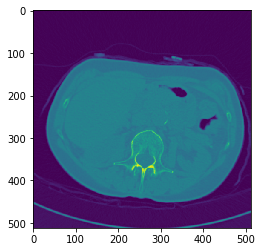

In [13]:
import matplotlib.pyplot as plt

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    #          the first slice
    plt.imshow(slices[0].pixel_array)
    plt.show()

/home/amir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


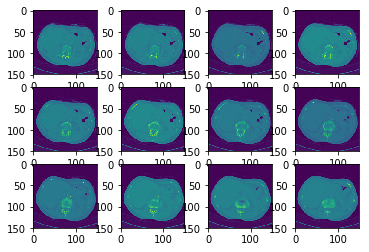

In [14]:
import cv2
import numpy as np

IMG_PX_SIZE = 150

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    fig = plt.figure()
    for num,each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3,4,num+1)
        new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_img)
    plt.show()

In [15]:
import math

def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def mean(l):
    return sum(l) / len(l)

IMG_PX_SIZE = 150
HM_SLICES = 20

data_dir = 'D:/Project/Lung Nodule/kaggle/sample_images/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('D:/Project/Lung Nodule/kaggle/csv/stage1_labels.csv', index_col=0)

for patient in patients[:10]:
    try:
        label = labels_df.get_value(patient, 'cancer')
        path = data_dir + patient
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []
        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
        chunk_sizes = math.ceil(len(slices) / HM_SLICES)
        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        print(len(slices), len(new_slices))
    except:
        # some patients don't have labels, so we'll just pass on this for now
        pass


/home/amir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


203 19
147 19
280 20
136 20
177 20
164 19
113 19
183 19
110 19


In [16]:
for patient in patients[:10]:
    try:
        label = labels_df.get_value(patient, 'cancer')
        path = data_dir + patient
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []

        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]

        chunk_sizes = math.ceil(len(slices) / HM_SLICES)


        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        if len(new_slices) == HM_SLICES-1:
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES-2:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES+2:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        if len(new_slices) == HM_SLICES+1:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        print(len(slices), len(new_slices))
    except Exception as e:
        # again, some patients are not labeled, but JIC we still want the error if something
        # else is wrong with our code
        print(str(e))

/home/amir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


203 20
'output_resize_150'
147 20
280 20
136 20
177 20
164 20
113 20
183 20
110 20


/home/amir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


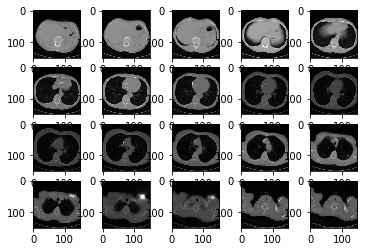

In [17]:
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    new_slices = []

    slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / HM_SLICES)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == HM_SLICES-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
        
    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
    
    fig = plt.figure()
    for num,each_slice in enumerate(new_slices):
        y = fig.add_subplot(4,5,num+1)
        y.imshow(each_slice, cmap='gray')
    plt.show()


In [3]:
import numpy as np
import pandas as pd
import pydicom as dicom
import os
import matplotlib.pyplot as plt
import cv2
import math

IMG_SIZE_PX = 50
SLICE_COUNT = 20

def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

 
#
# #n-sized chunks from list l
# def chunks( l,n ):
#     count=0
#     for i in range(0, len(l), n):
#         if(count < HM_SLICES):
#             yield l[i:i + n]
#             count=count+1       
        
        
        

def mean(a):
    return sum(a) / len(a)


def process_data(patient,labels_df,img_px_size=50, hm_slices=20, visualize=False):
    
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == hm_slices-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == hm_slices+1:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()

#     if label == 1: label=np.array([0,1])
#     elif label == 0: label=np.array([1,0])
        
    return np.array(new_slices),label

#                                               stage 1 for real.
#data_dir = '../input/sample_images/'
data_dir = 'D:/Project/Lung Nodule/kaggle/sample_images/'
patients = os.listdir(data_dir)
os.listdir(os.getcwd())# get the all in the current folder
labels = pd.read_csv('D:/Project/Lung Nodule/kaggle/csv/stage1_labels.csv', index_col=0)

much_data = []
for num,patient in enumerate(patients):
    if num % 100 == 0:
        print(num)
    try:
        img_data,label = process_data(patient,labels,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
        much_data.append([img_data,label])
    except KeyError as e:
        print('This is unlabeled data!')

np.save('muchdata-{}-{}-{}.npy'.format(IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT), much_data)

In [19]:
#data?


In [4]:
import numpy as np
much_data = np.load('muchdata-50-50-20.npy')

Y=much_data[:,1]
X=much_data[:,0]

In [15]:
X.shape

(20,)

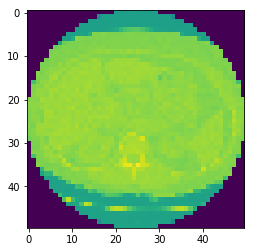

In [7]:
plt.imshow((X[1])[1,:,:])
plt.show()

In [6]:
train=[]
for i in range(len(X)):
    train.append(X[i])
    
    
    

In [7]:
train=np.asarray(train)

In [8]:
train[1].shape

(20, 50, 50)

In [9]:
train.shape

(20, 20, 50, 50)

In [10]:
train=np.reshape(train,(len(train),50,50,20,1))

In [11]:
train.shape

(20, 50, 50, 20, 1)

In [12]:
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras import optimizers

input_shape=(50,50,20,1)
model = Sequential()
model.add(Conv3D(32, kernel_size=(2,2,2),activation='relu',input_shape=input_shape,padding = 'same'))
model.add(Conv3D(32, (3, 3,3), activation='relu',padding = 'same'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Conv3D(64, (3, 3,3), activation='relu',padding = 'same'))
model.add(Conv3D(64, (3, 3,3), activation='relu',padding = 'same'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))

model.add(Conv3D(128, (3, 3,3), activation='relu',padding = 'same'))
model.add(Conv3D(128, (3, 3,3), activation='relu',padding = 'same'))
model.add(Conv3D(128, (3, 3,3), activation='relu',padding = 'same'))

model.add(MaxPooling3D(pool_size=(2, 2,2)))

model.add(Conv3D(256, (3, 3,3), activation='relu',padding = 'same'))
model.add(Conv3D(256, (3, 3,3), activation='relu',padding = 'same'))
model.add(Conv3D(256, (3, 3,3), activation='relu',padding = 'same'))

model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Conv3D(256, (3, 3,3), activation='relu',padding = 'same'))
model.add(Conv3D(256, (3, 3,3), activation='relu',padding = 'same'))
model.add(Conv3D(256, (3, 3,3), activation='relu',padding = 'same'))

#model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dense(2048, activation='relu'))

model.add(Dense(1, activation='sigmoid'))


C:\Users\Marya\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
import numpy as np
import pandas as pd
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import warnings
import keras 

from skimage import measure, morphology
from skimage.transform import resize

from keras.models import Model
from keras.layers import Input, Dense, Convolution3D, MaxPooling3D, UpSampling3D, merge
from keras.optimizers import Adam,SGD
from keras import backend as K

def get_unet():
    inputs = Input((50,50,20,1))
    conv1 = Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Convolution3D(64, 3, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution3D(64, 3, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Convolution3D(128, 3, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution3D(128, 3, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Convolution3D(256, 3, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution3D(256, 3, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    conv5 = Convolution3D(512, 3, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution3D(512, 3, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling3D(size=(2, 2, 2))(conv5), conv4], mode='concat', concat_axis=-1)
    conv6 = Convolution3D(256, 3, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution3D(256, 3, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling3D(size=(2, 2, 2))(conv6), conv3], mode='concat', concat_axis=-1)
    conv7 = Convolution3D(128, 3, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution3D(128, 3, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling3D(size=(2, 2, 2))(conv7), conv2], mode='concat', concat_axis=-1)
    conv8 = Convolution3D(64, 3, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution3D(64, 3, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling3D(size=(2, 2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution3D(1, 1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [13]:
#model = get_unet()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 50, 50, 20, 32)    288       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 50, 50, 20, 32)    27680     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 25, 25, 10, 32)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 25, 25, 10, 64)    55360     
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 25, 25, 10, 64)    110656    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 12, 12, 5, 64)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 12, 12, 5, 128)    221312    
__________

In [14]:


sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train,Y,batch_size=1,epochs=10,verbose=1,)

Epoch 1/10
20/20 [==============================] - 23s 1s/step - loss: 1.4180 - acc: 0.5500
Epoch 2/10
20/20 [==============================] - 1s 49ms/step - loss: 4.0464 - acc: 0.7500
Epoch 3/10
20/20 [==============================] - 1s 49ms/step - loss: 4.0295 - acc: 0.7500
Epoch 4/10
20/20 [==============================] - 1s 49ms/step - loss: 4.0295 - acc: 0.7500
Epoch 5/10
20/20 [==============================] - 1s 49ms/step - loss: 4.0295 - acc: 0.7500
Epoch 6/10
20/20 [==============================] - 1s 49ms/step - loss: 4.0295 - acc: 0.7500
Epoch 7/10
20/20 [==============================] - 1s 49ms/step - loss: 4.0295 - acc: 0.7500
Epoch 8/10
20/20 [==============================] - 1s 49ms/step - loss: 4.0295 - acc: 0.7500
Epoch 9/10
20/20 [==============================] - 1s 49ms/step - loss: 4.0295 - acc: 0.7500
Epoch 10/10
20/20 [==============================] - 1s 50ms/step - loss: 4.0295 - acc: 0.7500
